# Practical 9: Dimensions in Data

## 0. Setting up

In [80]:
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sklearn

In [4]:
from IPython.display import display_markdown

# This has been expanded to try to print out Pandas Series
# objects a little more intelligently as a Markdown table!
# We use f-strings everywhere because it ensures that we
# are working with string outputs.
def markdown_body(txt):
    if type(txt)==str:
        return "> " + txt
    elif type(txt)==pd.core.series.Series:
        out = '| Index | Value |\n| :----- | -----: |\n'
        for i in range(0,txt.shape[0]):
            out += f"| {txt.index[i]} | "
            if type(txt.iloc[i])==float or type(txt.iloc[i])==int or type(txt.iloc[i])==np.float64:
                out += f"{txt.iloc[i]:0.2f}"
            else:
                out += f"{txt.iloc[i]}"
            out += ' |\n'
        return out
    else:
        print(type(txt))
        return "> " + txt

# Notice how this has changed slightly to 
# call a function in the f-string instead
# of simply outputting the value. So we have
# a function calling a function!
def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n{markdown_body(body)}\n", raw=True)
    else:
        display_markdown(f"{markdown_body(body)}\n", raw=True)

In [11]:
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading")

    else:
        print(f"Found {dfn} locally!")

    return dfn

## 1. Loading and preparing data

### 1.1 Loading data

In [12]:
# Reading MSOA atlas data from Excel
url = 'https://data.london.gov.uk/download/msoa-atlas/39fdd8eb-e977-4d32-85a4-f65b92f29dcb/msoa-data.xls'
ddir  = os.path.join('data','raw')

msoa_atlas = pd.read_excel(cache_data(url, ddir), 
    sheet_name='iadatasheet1', # Which sheet is the data in?
    header=[0,1,2])            # Where are the column names... there's three of them!

Found data/raw/msoa-data.xls locally!


In [10]:
msoa_atlas.head(3)

Unnamed: 0_level_0        Unnamed: 1_level_0 Age Structure (2011 Census)  \
  Unnamed: 0_level_1        Unnamed: 1_level_1                    All Ages   
           MSOA Code                 MSOA Name          Unnamed: 2_level_2   
0          E02000001        City of London 001                      7375.0   
1          E02000002  Barking and Dagenham 001                      6775.0   
2          E02000003  Barking and Dagenham 002                     10045.0   

                                                                               \
                0-15              16-29              30-44              45-64   
  Unnamed: 3_level_2 Unnamed: 4_level_2 Unnamed: 5_level_2 Unnamed: 6_level_2   
0              620.0             1665.0             2045.0             2010.0   
1             1751.0             1277.0             1388.0             1258.0   
2             2247.0             1959.0             2300.0             2259.0   

                                        Mid-year Estimate totals  ...  \
                 65+        Working-age                 All Ages  ...   
  Unnamed: 7_level_2 Unnamed: 8_level_2                     2002  ...   
0             1035.0             5720.0                   7280.0  ...   
1             1101.0             3923.0                   6333.0  ...   
2             1280.0             6518.0                   9236.0  ...   

  Road Casualties                                                           \
             2010             2011                            2012           
           Slight 2010 Total Fatal Serious Slight 2011 Total Fatal Serious   
0           334.0      374.0   0.0    46.0  359.0      405.0   2.0    51.0   
1            18.0       18.0   0.0     2.0   16.0       18.0   0.0     1.0   
2            34.0       37.0   1.0     4.0   40.0       45.0   0.0     3.0   

                     
                     
  Slight 2012 Total  
0  361.0      414.0  
1   15.0       16.0  
2   47.0       50.0  

[3 rows x 207 columns]

In [13]:
print(f"Shape of the MSOA Atlas data frame is: {msoa_atlas.shape[0]} x {msoa_atlas.shape[1]}")

Shape of the MSOA Atlas data frame is: 984 x 207


### 1.2 Cleaning up the column names

In [14]:
print(msoa_atlas.columns.get_level_values(0))

Index(['Unnamed: 0_level_0', 'Unnamed: 1_level_0',
       'Age Structure (2011 Census)', 'Age Structure (2011 Census)',
       'Age Structure (2011 Census)', 'Age Structure (2011 Census)',
       'Age Structure (2011 Census)', 'Age Structure (2011 Census)',
       'Age Structure (2011 Census)', 'Mid-year Estimate totals',
       ...
       'Road Casualties', 'Road Casualties', 'Road Casualties',
       'Road Casualties', 'Road Casualties', 'Road Casualties',
       'Road Casualties', 'Road Casualties', 'Road Casualties',
       'Road Casualties'],
      dtype='object', length=207)


In [15]:
msoa_atlas[['Mid-year Estimate totals']].head(3)

Mid-year Estimate totals                                                  \
                  All Ages                                                   
                      2002    2003    2004    2005    2006    2007    2008   
0                   7280.0  7115.0  7118.0  7131.0  7254.0  7607.0  7429.0   
1                   6333.0  6312.0  6329.0  6341.0  6330.0  6323.0  6369.0   
2                   9236.0  9252.0  9155.0  9072.0  9144.0  9227.0  9564.0   

                                      
                                      
     2009     2010     2011     2012  
0  7472.0   7338.0   7412.0   7604.0  
1  6570.0   6636.0   6783.0   6853.0  
2  9914.0  10042.0  10088.0  10218.0

In [16]:
to_drop = ['Mid-year Estimate totals','Mid-year Estimates 2012, by age','Religion (2011)',
           'Land Area','Lone Parents (2011 Census)','Central Heating (2011 Census)','Health (2011 Census)',
           'Low Birth Weight Births (2007-2011)','Obesity','Incidence of Cancer','Life Expectancy',
           'Road Casualties']
msoa_atlas.drop(to_drop, axis=1, level=0, inplace=True)
print(f"Shape of the MSOA Atlas data frame is now: {msoa_atlas.shape[0]} x {msoa_atlas.shape[1]}")

Shape of the MSOA Atlas data frame is now: 984 x 111


In [17]:
print(msoa_atlas.columns.levels[0]) # The categories
print(msoa_atlas.columns.get_level_values(0)) # The actual values

Index(['Adults in Employment (2011 Census)', 'Age Structure (2011 Census)',
       'Car or van availability (2011 Census)',
       'Central Heating (2011 Census)', 'Country of Birth (2011)',
       'Dwelling type (2011)', 'Economic Activity (2011 Census)',
       'Ethnic Group (2011 Census)', 'Health (2011 Census)', 'House Prices',
       'Household Composition (2011)', 'Household Income Estimates (2011/12)',
       'Household Language (2011)', 'Households (2011)', 'Incidence of Cancer',
       'Income Deprivation (2010)', 'Land Area', 'Life Expectancy',
       'Lone Parents (2011 Census)', 'Low Birth Weight Births (2007-2011)',
       'Mid-year Estimate totals', 'Mid-year Estimates 2012, by age',
       'Obesity', 'Population Density', 'Qualifications (2011 Census)',
       'Religion (2011)', 'Road Casualties', 'Tenure (2011)',
       'Unnamed: 0_level_0', 'Unnamed: 1_level_0'],
      dtype='object')
Index(['Unnamed: 0_level_0', 'Unnamed: 1_level_0',
       'Age Structure (2011 Census

In [18]:
to_drop = [x for x in msoa_atlas.columns.get_level_values(1) if (
    x.endswith("(%)") or x.startswith("%") or x.endswith("Percentages") or x.endswith("%"))]
print(to_drop)

['Percentages', 'Percentages', 'Percentages', 'Percentages', 'Percentages', 'White (%)', 'Mixed/multiple ethnic groups (%)', 'Asian/Asian British (%)', 'Black/African/Caribbean/Black British (%)', 'Other ethnic group (%)', 'BAME (%)', 'United Kingdom (%)', 'Not United Kingdom (%)', '% of people aged 16 and over in household have English as a main language', '% of households where no people in household have English as a main language', 'Owned: Owned outright (%)', 'Owned: Owned with a mortgage or loan (%)', 'Social rented (%)', 'Private rented (%)', 'Household spaces with at least one usual resident (%)', 'Household spaces with no usual residents (%)', 'Whole house or bungalow: Detached (%)', 'Whole house or bungalow: Semi-detached (%)', 'Whole house or bungalow: Terraced (including end-terrace) (%)', 'Flat, maisonette or apartment (%)', 'Economically active %', 'Economically inactive %', '% of households with no adults in employment: With dependent children', '% living in income depri

In [19]:
msoa_atlas.drop(to_drop, axis=1, level=1, inplace=True)
print(f"Shape of the MSOA Atlas data frame is now: {msoa_atlas.shape[0]} x {msoa_atlas.shape[1]}")

Shape of the MSOA Atlas data frame is now: 984 x 76


In [20]:
msoa_atlas.columns.values[:3]

array([('Unnamed: 0_level_0', 'Unnamed: 0_level_1', 'MSOA Code'),
       ('Unnamed: 1_level_0', 'Unnamed: 1_level_1', 'MSOA Name'),
       ('Age Structure (2011 Census)', 'All Ages', 'Unnamed: 2_level_2')],
      dtype=object)

In [21]:
new_cols = []
for c in msoa_atlas.columns.values:
    
    #print(f"Column label: {c}")
    l1 = f"{c[0]}"
    l2 = f"{c[1]}"
    l3 = f"{c[2]}"
    
    # The new column label
    clabel = ''
    
    # Assemble new label from the levels
    if not l1.startswith("Unnamed"):
        l1 = l1.replace(" (2011 Census)",'').replace(" (2011)",'').replace("Household ",'').replace("House Prices",'').replace("Car or van availability",'Vehicles').replace(' (2011/12)','')
        l1 = l1.replace('Age Structure','Age').replace("Ethnic Group",'').replace('Dwelling type','').replace('Income Estimates','')
        clabel += l1
    if not l2.startswith("Unnamed"):
        l2 = l2.replace("Numbers",'').replace(" House Price (£)",'').replace("Highest level of qualification: ",'').replace("Annual Household Income (£)",'hh Income').replace('Whole house or bungalow: ','').replace(' qualifications','')
        l2 = l2.replace('At least one person aged 16 and over in household has English as a main language',"1+ English as a main language").replace("No people in household have English as a main language","None have English as main language")
        clabel += (' - ' if clabel != '' else '') + l2
    if not l3.startswith("Unnamed"):
        clabel += (' - ' if clabel != '' else '') + l3
    
    # Replace other commonly-occuring verbiage that inflates column name width
    clabel = clabel.replace(' -  - ',' - ').replace(" household",' hh').replace('Owned: ','')
    
    #clabel = clabel.replace(' (2011 Census)','').replace(' (2011)','').replace('Sales - 2011.1','Sales - 2012')
    #clabel = clabel.replace('Numbers - ','').replace(' (£)','').replace('Car or van availability','Vehicles')
    #clabel = clabel.replace('Household Income Estimates (2011/12) - ','').replace('Age Structure','Age')
    
    new_cols.append(clabel)

print(new_cols)

['MSOA Code', 'MSOA Name', 'Age - All Ages', 'Age - 0-15', 'Age - 16-29', 'Age - 30-44', 'Age - 45-64', 'Age - 65+', 'Age - Working-age', 'Households - All Households', 'Composition - Couple hh with dependent children', 'Composition - Couple hh without dependent children', 'Composition - Lone parent hh', 'Composition - One person hh', 'Composition - Other hh Types', 'White', 'Mixed/multiple ethnic groups', 'Asian/Asian British', 'Black/African/Caribbean/Black British', 'Other ethnic group', 'BAME', 'Country of Birth - United Kingdom', 'Country of Birth - Not United Kingdom', 'Language - 1+ English as a main language', 'Language - None have English as main language', 'Tenure - Owned outright', 'Tenure - Owned with a mortgage or loan', 'Tenure - Social rented', 'Tenure - Private rented', 'Household spaces with at least one usual resident', 'Household spaces with no usual residents', 'Detached', 'Semi-detached', 'Terraced (including end-terrace)', 'Flat, maisonette or apartment', 'Populat

In [22]:
msoa_atlas.columns = new_cols
msoa_atlas.head()

,MSOA Code,MSOA Name,Age - All Ages,Age - 0-15,Age - 16-29,Age - 30-44,Age - 45-64,Age - 65+,Age - Working-age,Households - All Households,...,Adults in Employment - No adults in employment in hh: With dependent children,Total Mean hh Income,Total Median hh Income,Vehicles - No cars or vans in hh,Vehicles - 1 car or van in hh,Vehicles - 2 cars or vans in hh,Vehicles - 3 cars or vans in hh,Vehicles - 4 or more cars or vans in hh,Vehicles - Sum of all cars or vans in the area,Vehicles - Cars per hh
0,E02000001,City of London 001,7375.0,620.0,1665.0,2045.0,2010.0,1035.0,5720.0,4385.0,...,38.0,59728.481886,46788.295472,3043.0,1100.0,173.0,51.0,18.0,1692.0,0.385861
1,E02000002,Barking and Dagenham 001,6775.0,1751.0,1277.0,1388.0,1258.0,1101.0,3923.0,2713.0,...,319.0,31788.185996,27058.703760,1020.0,1186.0,424.0,66.0,17.0,2305.0,0.849613
2,E02000003,Barking and Dagenham 002,10045.0,2247.0,1959.0,2300.0,2259.0,1280.0,6518.0,3834.0,...,268.0,43356.931547,36834.528738,1196.0,1753.0,691.0,155.0,39.0,3766.0,0.982264
3,E02000004,Barking and Dagenham 003,6182.0,1196.0,1277.0,1154.0,1543.0,1012.0,3974.0,2318.0,...,122.0,46701.436554,39668.206433,556.0,1085.0,515.0,128.0,34.0,2650.0,1.143227
4,E02000005,Barking and Dagenham 004,8562.0,2200.0,1592.0,1995.0,1829.0,946.0,5416.0,3183.0,...,307.0,34293.820288,29155.683536,1080.0,1423.0,551.0,109.0,20.0,2937.0,0.922714


### 1.3 Adding subregion category

In [23]:
msoa_atlas['Borough'] = msoa_atlas['MSOA Name'].str.replace(' \d+$','')

/tmp/ipykernel_1228/461402212.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  msoa_atlas['Borough'] = msoa_atlas['MSOA Name'].str.replace(' \d+$','')


In [24]:
# You might want to have a look at _what_ this drops first
msoa_atlas.drop(index=msoa_atlas[msoa_atlas['MSOA Code'].isna()].index, inplace=True)

In [25]:
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden','City of London']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet']:
    mapping[b]='Outer West and North West'

msoa_atlas['Subregion'] = msoa_atlas.Borough.apply(lambda x: mapping[x])

### 1.4 Save the cleaned data

In [26]:
msoa_atlas.to_csv(os.path.join('data','clean','MSOA_Atlas.csv.gz'), index=False)
print("Done.")

Done.


### 1.5 Combinig with geographic data (gpkg)

In [27]:
# Using London_MSOAS geopackage created last time
msoas = gpd.read_file(os.path.join('data','clean','London_MSOAs.gpkg'), driver='GPKG')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [28]:
gdf = pd.merge(msoas, msoa_atlas, left_on='MSOA11CD', right_on='MSOA Code', how='inner')

gdf = gdf.drop(columns=['MSOA11CD','MSOA11NM', 'Borough_x']).rename(columns={'Borough_y':'Borough'})

print(f"Final MSOA Atlas data frame has shape {gdf.shape[0]:,} x {gdf.shape[1]}")

Final MSOA Atlas data frame has shape 983 x 83


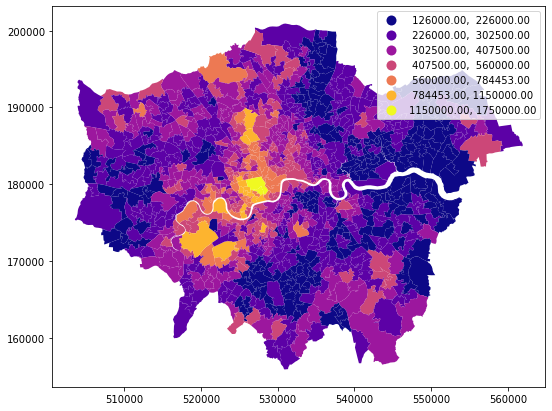

In [29]:
gdf.plot(column='Median - 2011', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));

In [30]:
gdf.to_file(os.path.join('data','clean','MSOA_Atlas.gpkg'), driver='GPKG')
print("Done.")

Done.


In [32]:
# Forcing the category variable type
categoricals = ['Borough','Subregion']
for c in categoricals:
    gdf[c] = gdf[c].astype('category')

## 2. Splitting data to training and testing datasets

Typically, you would take 80-90% of your data to 'train' your algorithm and withold between 10-20% for validation ('testing'). An even 'stricter' approach, in the sense of trying to ensure the robustness of your model against outlier effects, is cross validation such as k-folds cross-validation. Ordinarily, you would use this when building a model where you have both predictors _and_ a target.

In [38]:
from sklearn.model_selection import train_test_split 

pdf = gdf['Median - 2011'].copy()                                                                  # Variables to predict
df_train, df_test, pr_train, pr_test = train_test_split(gdf, pdf, test_size=0.2, random_state=44)  # df: explanatory df, pr: target list


In [34]:
print(f"Original data size: {gdf.shape[0]:,} x {gdf.shape[1]}")
print(f"Training data size: {df_train.shape[0]:,} x {df_train.shape[1]}")
print(f"Testing data size:  {df_test.shape[0]:,} x {df_test.shape[1]}")

Original data size: 983 x 83
Training data size: 786 x 83
Testing data size:  197 x 83


In [47]:
# Check that the index of training data are teh same for both df and pr
print(", ".join([str(x) for x in df_train.index[:10]]))
print(", ".join([str(x) for x in pr_train.index[:10]]))

810, 502, 471, 74, 415, 316, 15, 37, 877, 449
810, 502, 471, 74, 415, 316, 15, 37, 877, 449


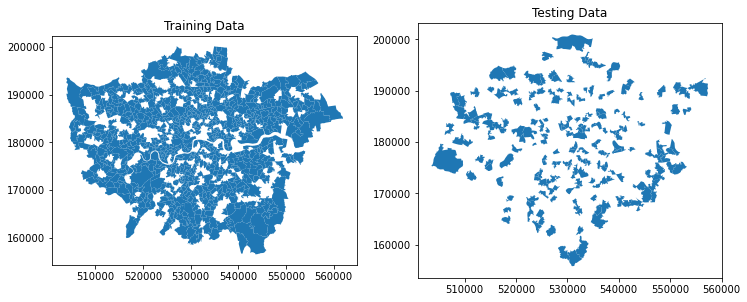

In [48]:
# Plotting Training and Testing data (MSOAS split into two)
f,axes = plt.subplots(1,2, figsize=(12,5))
df_train.plot(ax=axes[0])
df_test.plot(ax=axes[1])
axes[0].set_title('Training Data')
axes[1].set_title('Testing Data');

## 3. Normalisation

The developers of [SciKit-Learn](https://scikit-learn.org/) define [normalisation](https://scikit-learn.org/stable/modules/preprocessing.html#normalization) as "scaling individual samples to have **unit norm**." There are a _lot_ of subtleties to this when you start dealing with 'sparse' data, but for the most part it's worthwhile to think of this as a rescaling of the raw data to have similar ranges in order achieve some kind of comparison.

In [49]:
# Sets some handy 'keywords' to tweak the Seaborn plot
kwds = dict(s=7,alpha=0.95,edgecolor="none")

# Set the *hue order* so that all plots have some colouring by Subregion
ho = ['Inner East','Inner West','Outer West and North West','Outer South','Outer East and North East']

In [50]:
cols = ['Tenure - Owned outright', 'Tenure - Owned with a mortgage or loan',
        'Tenure - Social rented', 'Tenure - Private rented']

In [55]:
# Train the scaler functions for the 4 columns specified

from sklearn.preprocessing import MinMaxScaler # (X-min)/(max-min)
scalers = [MinMaxScaler().fit(df_train[x].values.reshape(-1,1)) for x in cols]

scalers

[MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()]

In [58]:
# Normalising the training dataframe

df_train_normed = df_train[cols+['Subregion']].copy()
df_train_normed.head()

for i in range(0, len(cols)):
    df_train_normed[cols[i]] = scalers[i].transform(df_train[cols[i]].values.reshape(-1,1))

In [60]:
df_train_normed.head()

,Tenure - Owned outright,Tenure - Owned with a mortgage or loan,Tenure - Social rented,Tenure - Private rented,Subregion
810,0.162927,0.447520,0.437660,0.126905,Outer South
502,0.336098,0.409922,0.272059,0.184451,Outer West and North West
471,0.584390,0.548825,0.122123,0.055259,Outer East and North East
74,0.440000,0.609399,0.082801,0.054116,Outer East and North East
415,0.299512,0.332637,0.053389,0.500762,Inner East


In [62]:
# Normalising the testing dataframe

df_test_normed = df_test[cols+['Subregion']].copy()

for i in range(0, len(cols)):
    df_test_normed[cols[i]] = scalers[i].transform(df_test[cols[i]].values.reshape(-1,1))

In [66]:
# Cleaning up the column names with regex

df_train_normed.columns  = [re.sub('( - |/)',"\n",x) for x in df_train_normed.columns.values]
df_test_normed.columns = [re.sub('( - |/)',"\n",x) for x in df_test_normed.columns.values]

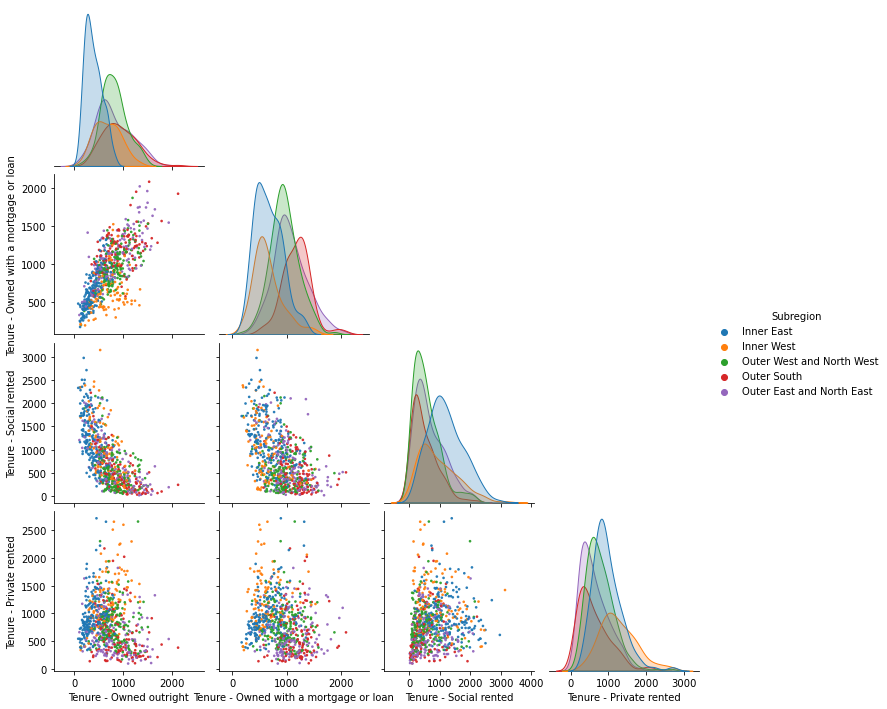

In [64]:
# Original training data
sns.pairplot(data=df_train[cols+['Subregion']], hue='Subregion', diag_kind='kde', corner=True, plot_kws=kwds, hue_order=ho);

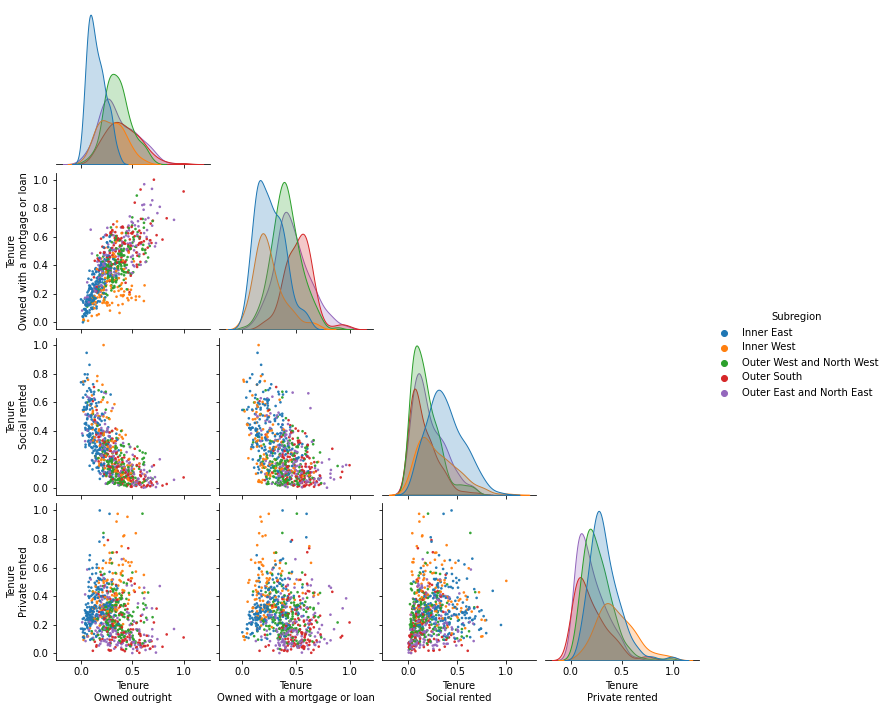

In [68]:
# Normalised training data
sns.pairplot(data=df_train_normed, hue='Subregion', diag_kind='kde', corner=True, plot_kws=kwds, hue_order=ho);

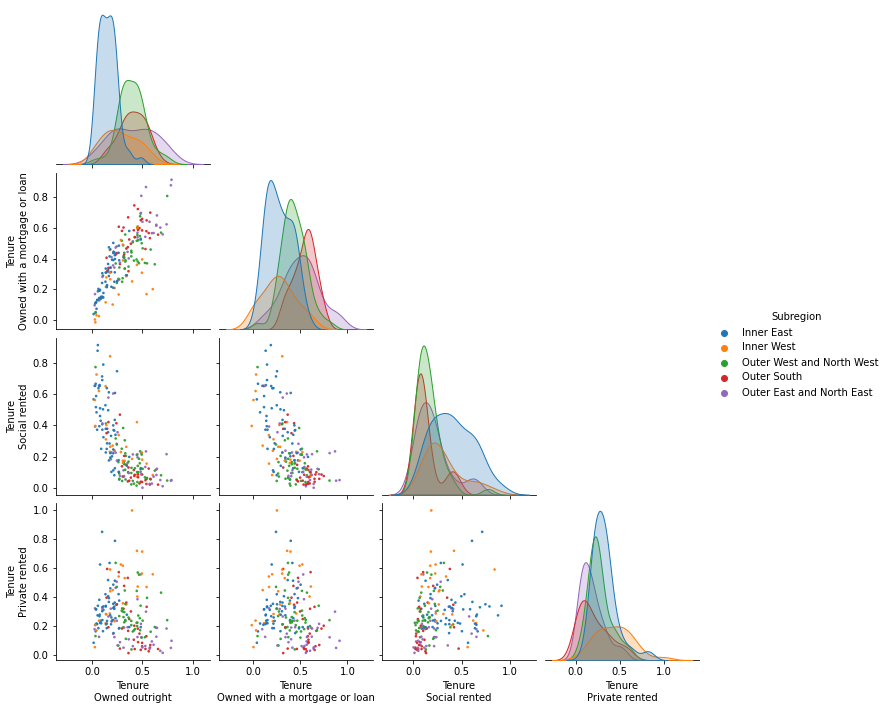

In [69]:
# Normalised test data
sns.pairplot(data=df_test_normed, hue='Subregion', diag_kind='kde', corner=True, plot_kws=kwds, hue_order=ho);

Issue - some values from normalised test data may exceed 1 or below 0

## 4. Standardisation

Standardisation is typically focussed on rescaling data to have a mean (or median) of 0 and standard deviation or IQR of 1

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [71]:
# 1. Define column(s) of interest and copy data
col = 'Vehicles - No cars or vans in hh'
tr  = df_train[[col]].copy()
tst = df_test[[col]].copy()

In [74]:
# Z-score (StandardScaler())

# 2. Fit the scaler
ss = StandardScaler()                
ss.fit(tr[col].values.reshape(-1,1))

# 3. Transform the training and test data
tr[f"Z. {col}"]  = ss.transform(tr[col].values.reshape(-1,1))
tst[f"Z. {col}"] = ss.transform(tst[col].values.reshape(-1,1))

In [75]:
# Inter-quartile standardisation (RobustScaler())

# 2. Fit the scaler
rs = RobustScaler(quantile_range=(25.0, 75.0))
rs.fit(tr[col].values.reshape(-1,1))

# 3. Transform the training and test data
tr[f"IQR. {col}"] = rs.transform(tr[col].values.reshape(-1,1))
tst[f"IQR. {col}"] = rs.transform(tst[col].values.reshape(-1,1))

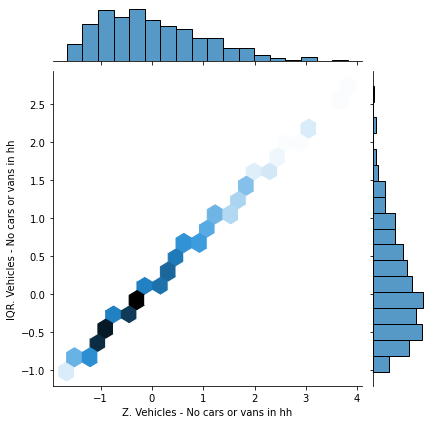

In [76]:
# Plotting the results - x: z-score, y: IQR standardisation
sns.jointplot(data=tr, x=f"Z. {col}", y=f"IQR. {col}", kind='hex'); # hex probably not the best choice

Text(0.5, 0, 'Standardised Value for No cars or vans in hh')

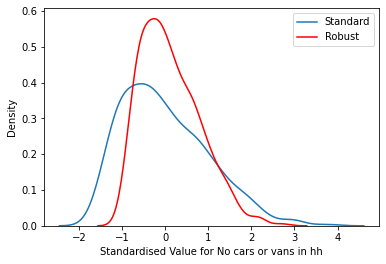

In [77]:
# Similarly:
ax = sns.kdeplot(tr[f"Z. {col}"])
sns.kdeplot(tr[f"IQR. {col}"], color='r', ax=ax)
plt.legend(loc='upper right', labels=['Standard', 'Robust']) # title='Foo'
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Standardised Value for No cars or vans in hh")

Notice that the Robust Scaler output now has less skew than the output from the Standard Scaler. So when dealing with heavy skew you'd find the Robust scaler more useful. If you treated the skewed data using z-scores you'd be more likely to find values _statistically significant_ on either side. 

## 5. Non-linear transformation

### 5.1 Assessing how normal the distribution is

In [78]:
# Function to create a set of random numbers from a normal distribution with series' mean and stdv

def normal_from_dist(series):  
    mu = series.mean()         
    sd = series.std()         
    n  = len(series)           
    s = np.random.normal(mu, sd, n)   
    return s                  

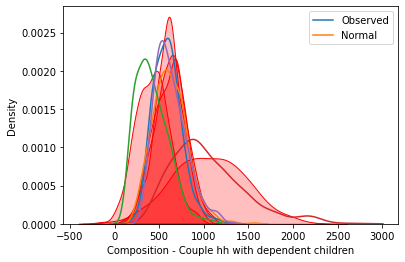

In [85]:
to_plot = [x for x in df_train.columns.values if x.startswith('Composition')]

for c in to_plot:
    ax = sns.kdeplot(df_train[c])
    sns.kdeplot(normal_from_dist(df_train[c]), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal']) # title='Foo'
    ax.ticklabel_format(useOffset=False, style='plain')
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    #plt.show()

Note - these values should have been normalised using proportions rather than using a raw count

### 5.2 Log transformation

There is no log transformation function in pandas, so use one from numpy
```python
series = pd.Series(np.log(df.<series>))
```

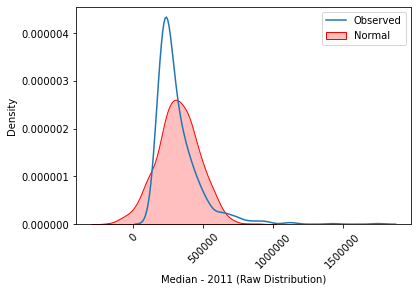

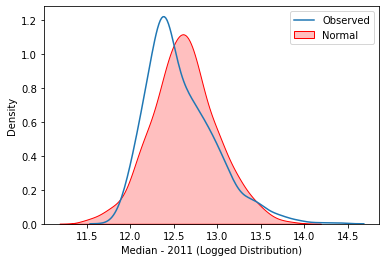

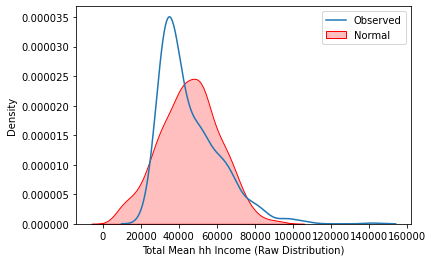

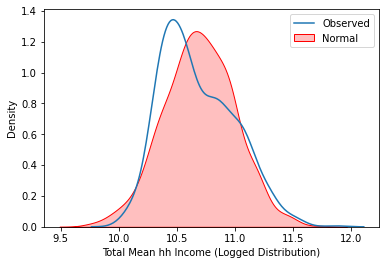

In [84]:
cols = ['Median - 2011','Total Mean hh Income']

for m in cols:
    s  = df_train[m] # s == series
    ts = np.log(s)   # ts == transformed series
    
    ax = sns.kdeplot(s)
    sns.kdeplot(normal_from_dist(s), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal']) # title also an option
    
    ### USEFUL FORMATTING TRICKS ###
    # This turns off scientific notation in the ticklabels
    ax.ticklabel_format(useOffset=False, style='plain')
    # Notice this snippet of code
    ax.set_xlabel(ax.get_xlabel() + " (Raw Distribution)")
    # Notice this little code snippet too
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    
    plt.show()
    
    ax = sns.kdeplot(ts)
    sns.kdeplot(normal_from_dist(ts), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal'])
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel(ax.get_xlabel() + " (Logged Distribution)")
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    plt.show()

## 6. Principal Components Analysis

Now we're going to ask the question: how can we represent our data using a smaller number of components that capture the variance in the original data.
To perform PCA we can only have numeric data. In theory, categorical data can be converted to numeric and retained, but there are two issues:

1. Nominal data has no _innate_ order so we _can't_ convert > 2 categories to numbers and have to convert them to One-Hot Encoded values.
2. A binary (i.e. One-Hot Encoded) variable will account for a _lot_ of variance in the data because it's only two values are 0 and 1!

### 6.1 Performing PCA

In [87]:
# 1. Drop non-numeric data

to_drop = ['OBJECTID', 'BNG_E', 'BNG_N', 'msoa11hclnm', 
           'MSOA Name', 'Borough', 'Subregion', 'geometry']
gdf_pca = gdf.drop(columns=to_drop).set_index('MSOA Code').copy()

In [88]:
# 2. Rescale to avoid a few variables dominate the results

rs = RobustScaler(quantile_range=(10.0, 90.0))

for c in gdf_pca.columns.values:
    gdf_pca[c] = rs.fit_transform(gdf_pca[c].values.reshape(-1, 1))  # Fit and transform

In [89]:
# 3. Perform PCA on the rescaled data

from sklearn.decomposition import PCA

# a. Define pca
pca = PCA(n_components=50, whiten=True) 
# b. Fit
pca.fit(gdf_pca)
# c. Extract info
explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_

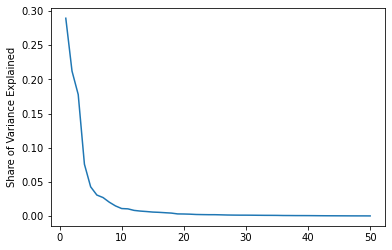

In [91]:
# Plot the amount of variance explained per component for 50 components

x = np.arange(1,len(explained_variance)+1)   # explained_variance = 50 as defined
plt.plot(x, explained_variance)
plt.ylabel('Share of Variance Explained')
plt.show()

In [92]:
# In number:
for i in range(0, 20):
    print(f"Component {i:>2} accounts for {explained_variance[i]*100:>2.2f}% of variance")

Component  0 accounts for 28.95% of variance
Component  1 accounts for 21.23% of variance
Component  2 accounts for 17.79% of variance
Component  3 accounts for 7.59% of variance
Component  4 accounts for 4.29% of variance
Component  5 accounts for 3.09% of variance
Component  6 accounts for 2.72% of variance
Component  7 accounts for 2.04% of variance
Component  8 accounts for 1.50% of variance
Component  9 accounts for 1.11% of variance
Component 10 accounts for 1.06% of variance
Component 11 accounts for 0.84% of variance
Component 12 accounts for 0.74% of variance
Component 13 accounts for 0.67% of variance
Component 14 accounts for 0.59% of variance
Component 15 accounts for 0.56% of variance
Component 16 accounts for 0.50% of variance
Component 17 accounts for 0.45% of variance
Component 18 accounts for 0.33% of variance
Component 19 accounts for 0.31% of variance


### 6.2 Selecting significant components

There are a number of ways that we could set a threshold for dimensionality reduction: 
- The most common is to look for the 'knee' in the Explained Variance plot above. That would put us at about 5 retained components.
- Another is to just keep all components contributing more than 1% of the variance. That would put us at about 10 components.
- You can also ([I discovered](https://medium.com/@nikolay.oskolkov/hi-jon-reades-my-sincere-apologies-for-this-very-late-reply-444f57054d14)) look to shuffle the data and repeatedly perform PCA to build confidence intervals.

In [104]:
keep_n_components = 10

# a. Define pca
pca = PCA(n_components=keep_n_components, whiten=True)

# b. Fit
X_train = pca.fit_transform(gdf_pca)

# c. Extract info
# We get the same values - this is a *deterministic* process that is fully replicable
for i in range(0, keep_n_components):
    print(f"Component {i:>2} accounts for {pca.explained_variance_ratio_[i]*100:>2.2f}% of variance")

print(len(X_train))        # 983
print(len(X_train[0]))     # 10
# X_train (PCA output) has a dinension of 983 x 10 <- training data entries x compnent count

print(gdf_pca.shape[0])
# So each observation has a row in X_train - this defines the mapping of the original data space into the reduced one


Component  0 accounts for 28.95% of variance
Component  1 accounts for 21.23% of variance
Component  2 accounts for 17.79% of variance
Component  3 accounts for 7.59% of variance
Component  4 accounts for 4.29% of variance
Component  5 accounts for 3.09% of variance
Component  6 accounts for 2.72% of variance
Component  7 accounts for 2.04% of variance
Component  8 accounts for 1.50% of variance
Component  9 accounts for 1.11% of variance
983
10
983


In [106]:
gdf_pca.shape

(983, 74)

### 6.3 Finding out the coefficients of each component

In [112]:
for x in [X_train]:
    print(x)
    new_columns = []
    
    for i in range(0,keep_n_components):
        new_columns.append([])                        # Adding empty columns x number of components

    for i in x:
        for j in range(0,keep_n_components):
            new_columns[j].append(i[j])               # Adding coefficient entries to i x j cell

    for i in range(0,keep_n_components):
        gdf_pca[f"Component {i+1}"] = new_columns[i]  # Appending above entry to the dataframe gdf_pca

[[ 2.72268905  0.90242102 -0.0979393  ... -1.46928904 -0.67853327
  -0.59480716]
 [-1.13173033 -0.43974924 -0.64673864 ...  0.05905896  0.15621623
   0.97885089]
 [-0.33742797 -0.16387771  1.61340701 ...  0.89839098  0.40769687
  -0.27981177]
 ...
 [ 0.18940163  0.380877   -0.27742044 ...  0.21950617  1.02374667
   0.4227126 ]
 [ 0.42527018 -0.19410902 -0.85462017 ...  1.08962885  0.46030745
  -0.18193293]
 [ 1.00694754  0.33423979  0.48445075 ...  0.20997305  0.32759806
   0.40906151]]


In [108]:
gdf_pca.sample(3)

,Age - All Ages,Age - 0-15,Age - 16-29,Age - 30-44,Age - 45-64,Age - 65+,Age - Working-age,Households - All Households,Composition - Couple hh with dependent children,Composition - Couple hh without dependent children,...,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10
MSOA Code,,,,,,,,,,,,,,,,,,,,,
E02000001,-0.216080,-0.869294,-0.070340,-0.010863,0.278122,0.208285,0.045933,0.682135,-0.697617,0.638559,...,2.722689,0.902421,-0.097939,-1.848379,0.157923,5.698354,4.444601,-1.469289,-0.678533,-0.594807
E02000186,-0.406430,-0.712375,0.155660,-0.115151,-0.459057,-0.205944,-0.134266,-0.065713,-0.764647,-0.102333,...,0.832833,0.529292,-1.687285,0.103645,0.320658,1.450073,-0.552371,0.656872,-0.615680,-0.174308
E02000493,-0.538402,-0.194365,-0.355608,-0.530852,-0.240902,-0.100632,-0.539891,-0.430914,-0.243297,-0.149406,...,-0.989177,-1.026343,-0.482089,-0.999870,0.343754,0.684257,0.916262,0.489905,-0.108065,-0.078127


### 6.4 Attaching the output to geodata

In [114]:
# Loading the data
msoas = gpd.read_file(os.path.join('data','clean','London_MSOAs.gpkg'), driver='GPKG')

In [116]:
# Merge the output dataframe with geopackage
pca_shape = pd.merge(msoas.set_index('MSOA11CD'), gdf_pca, left_index=True, right_index=True, how='inner')
print(f"PCA df has shape {pca_shape .shape[0]} x {pca_shape .shape[1]}")
pca_shape.sample(3)

PCA df has shape 983 x 91


,OBJECTID,MSOA11NM,BNG_E,BNG_N,Borough,msoa11hclnm,geometry,Age - All Ages,Age - 0-15,Age - 16-29,...,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10
MSOA11CD,,,,,,,,,,,,,,,,,,,,,
E02000200,195,Croydon 007,533678,168811,Croydon,South Norwood Hill,"POLYGON ((533816.063 169756.904, 533843.591 16...",0.038181,0.109665,-0.160870,...,-0.493356,0.314268,0.856208,-1.147901,0.467202,0.166365,0.810870,-0.474374,0.874975,-2.055737
E02000210,204,Croydon 017,533766,166798,Croydon,Addiscombe North,"POLYGON ((533861.575 167384.299, 533958.770 16...",0.042607,0.207739,-0.107464,...,-0.375592,-0.249862,0.719286,-0.813419,0.124404,-0.753324,0.878417,1.493128,0.911835,-1.548563
E02000713,689,Merton 025,523806,166838,Merton,Lower Morden,"POLYGON ((524089.371 167448.593, 524117.376 16...",-0.184263,-0.121255,-0.342582,...,-0.303902,-1.354923,0.199646,-0.268932,-0.111678,0.069272,0.600600,1.756746,-1.038242,-0.443684


In [117]:
type(pca_shape)

geopandas.geodataframe.GeoDataFrame

### 6.5 Map the components

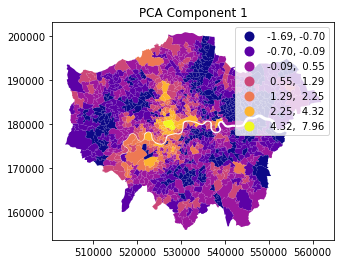

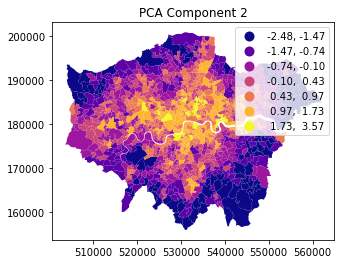

In [118]:
# Mapping each component

for i in range(1,3):
    ax = pca_shape.plot(column=f'Component {i}', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(6,4));
    ax.set_title(f'PCA Component {i}')

## 7. t-SNE (t-distributed stochastic neighbor embedding)

In [ ]:
from sklearn.manifold import TSNE

keep_dims=2
lrn_rate=150
prp=50

tsnedf = pcadf.loc[:,'Component 1':f"Component {keep_n_components}"].copy()

tsne = TSNE(n_components=keep_dims, perplexity=prp, random_state=42, n_iter=5000, n_jobs=-1)
X_embedded = tsne.fit_transform(tsnedf)
X_embedded.shape

In [ ]:
for x in [X_embedded]:
    new_columns = []
    
    for i in range(0,keep_dims):
        new_columns.append([])

    for i in x:
        for j in range(0,keep_dims):
            new_columns[j].append(i[j])

    for i in range(0,keep_dims):
        tsnedf[f"Dimension {i+1}"] = new_columns[i]

In [ ]:
rddf = pd.merge(msoas.set_index('MSOA11CD'), tsnedf, left_index=True, right_index=True, how='inner')
rddf.sample(3)

In [ ]:
rddf['Subregion'] = rddf.Borough.apply(lambda x: mapping[x])

In [ ]:
# Sets some handy 'keywords' to tweak the Seaborn plot
kwds = dict(s=7,alpha=0.95,edgecolor="none")
# Set the *hue order* so that all plots have some colouring by Subregion
ho = ['Inner East','Inner West','Outer West and North West','Outer South','Outer East and North East']

In [ ]:
g = sns.jointplot(data=rddf, x='Dimension 1', y='Dimension 2', 
                  hue='Subregion', hue_order=ho, joint_kws=kwds)
g.ax_joint.legend(loc='upper right', prop={'size': 8});

In [ ]:
for r in rddf.Subregion.unique():
    g = sns.jointplot(data=rddf[rddf.Subregion==r], x='Dimension 1', y='Dimension 2', 
                  hue='Borough', joint_kws=kwds)
    g.ax_joint.legend(loc='upper right', prop={'size': 8});
    plt.suptitle(r)

In [ ]:
rddf.to_file(os.path.join('data','clean','Reduced_Dimension_Data.gpkg'), driver='GPKG')